## Random Forest

В этом ноутбуке мы хотим протестировать Случайный лес с различными способами векторизации текста и способами уменьшения размерности. В качестве признаков мы будем использовать только тексты пресс-релизов.

In [1]:
import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
import seaborn as sns
import optuna

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

sns.set_style("whitegrid")

Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

### Предобработка текстов

Предобработаем тексты пресс-релизов.

In [ ]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


# Выполняем предобработку текстов
X_preproc = X.release.apply(preprocessor)

### TF-IDF SelectFromModel RandomForest

С помощью `SelectFromModel` отберем важные признаки, а в качестве основной модели будем использовать `RandomForestClassifier`. Для подбора гиперпараметров будем использовать `optuna`.

In [ ]:
def objective(trial):

    # параметры для перебора
    params = {
        "max_df": trial.suggest_float("max_df", 0.1, 1),
        "min_df": trial.suggest_int("min_df", 1, 10),
        "C": trial.suggest_float("C", 3, 500),
        "threshold": trial.suggest_float("threshold", 0, 1e-3),
        "max_depth": trial.suggest_int("max_depth", 1, 25),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params["max_df"], min_df=params["min_df"])
    tf_idf = vectorizer.fit_transform(X_preproc).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=42
    )
    selector = SelectFromModel(estimator, threshold=params["threshold"])

    # определяем pipeline
    pipeline = Pipeline(
        [
            ("selector", selector),
            (
                "model",
                RandomForestClassifier(
                    max_depth=params["max_depth"],
                    min_samples_leaf=params["min_samples_leaf"],
                    min_samples_split=params["min_samples_split"],
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
study.best_params

{'max_df': 0.5236548567863788,
 'min_df': 8,
 'C': 430.14450063610496,
 'threshold': 0.0001957786936279224,
 'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Обучим модель с лучшими гиперпараметрами и посмотрим на качество подробнее.

In [ ]:
# векторизуем текст
vectorizer = TfidfVectorizer(
    max_df=study.best_params["max_df"], min_df=study.best_params["min_df"]
)
tf_idf = vectorizer.fit_transform(X_preproc).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], random_state=42
)
selector = SelectFromModel(estimator, threshold=study.best_params["threshold"])

pipeline = Pipeline(
    [
        ("selector", selector),
        (
            "model",
            RandomForestClassifier(
                max_depth=study.best_params["max_depth"], random_state=42
            ),
        ),
    ]
)

              precision    recall  f1-score   support

        -1.0       0.75      0.65      0.70        23
         0.0       0.53      0.65      0.59        26
         1.0       0.75      0.63      0.69        19

    accuracy                           0.65        68
   macro avg       0.68      0.65      0.66        68
weighted avg       0.67      0.65      0.65        68



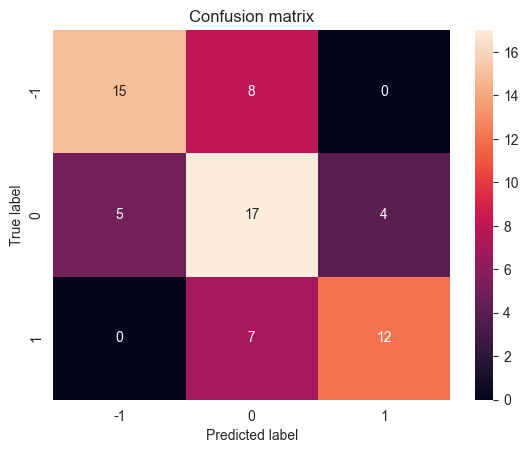

In [8]:
# вычисляем метрики
metrics, model = calc_metrics(
    tf_idf,
    y,
    pipeline,
    name="TF-IDF SelectFromModel Random Forest",
)

In [9]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF SelectFromModel Random Forest,0.647059,0.656532,0.645866,0.677083,0.802227,0.80869


Теперь попробуем уменьшить размерность с помощью `PCA`

### TF-IDF PCA Random Forest

In [ ]:
def objective(trial):

    # параметры для перебора
    params = {
        "max_df": trial.suggest_float("max_df", 0.1, 1),
        "min_df": trial.suggest_int("min_df", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 1, 25),
        "n_components": trial.suggest_int("n_components", 2, 29),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params["max_df"], min_df=params["min_df"])
    tf_idf = vectorizer.fit_transform(X_preproc).toarray()

    # определяем pipeline
    pipeline = Pipeline(
        [
            ("selector", PCA(n_components=params["n_components"])),
            (
                "model",
                RandomForestClassifier(
                    max_depth=params["max_depth"], random_state=42, n_jobs=-1
                ),
            ),
        ]
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/father/Desktop/cbr-press-release-classifier/ml/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
study.best_params

{'max_df': 0.9247089393815328, 'min_df': 6, 'max_depth': 9, 'n_components': 27}

Качество получилось немного лучше, посмотрим подробнее.

In [ ]:
# векторизуем текст
vectorizer = TfidfVectorizer(
    max_df=study.best_params["max_df"], min_df=study.best_params["min_df"]
)
tf_idf = vectorizer.fit_transform(X_preproc).toarray()

pipeline = Pipeline(
    [
        ("selector", PCA(n_components=study.best_params["n_components"])),
        (
            "model",
            RandomForestClassifier(
                max_depth=study.best_params["max_depth"], random_state=42, n_jobs=-1
            ),
        ),
    ]
)

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.53      0.69      0.60        26
         1.0       0.82      0.47      0.60        19

    accuracy                           0.63        68
   macro avg       0.68      0.62      0.63        68
weighted avg       0.67      0.63      0.63        68



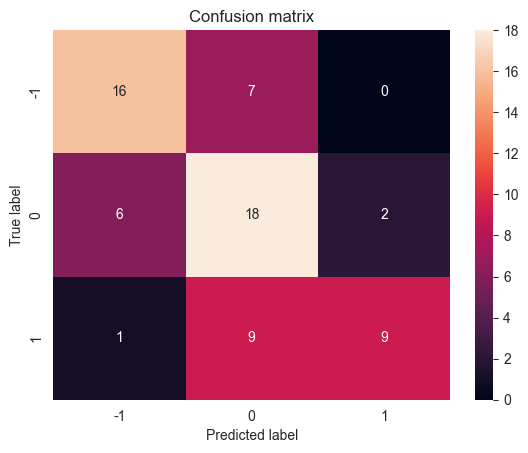

In [15]:
# вычисляем метрики
metric, model = calc_metrics(
    tf_idf,
    y,
    pipeline,
    name="TF-IDF PCA Random Forest",
)

In [16]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF SelectFromModel Random Forest,0.647059,0.656532,0.645866,0.677083,0.802227,0.808690
TF-IDF PCA Random Forest,0.632353,0.631884,0.620548,0.681082,0.817684,0.822178


Метрика roc_auc выросла, а вот accuracy снизилось, возможно стоит изменить пороги. Мы можем заметить, что в предсказании положительного класса модель ошибается чаще всего.

Теперь попробуем закодировать релизы с помощью `word2vec`, подберем размер окна.

### Word2Vec Random Forest

In [17]:
# предобработаем тексты и преобразуем в список слов
texts = X.release.map(preprocessor).str.split()

# создадим словарь для хранения метрик
best_models = {"window": [], "roc_auc": [], "model": []}

# обучаем word2vec c разными окнами
for window in tqdm(range(3, 20)):
    model = Word2Vec(
        sentences=texts, window=window, min_count=5, vector_size=30, sg=1, epochs=100
    )

    # Для каждого слова получаем эмбединг, если оно попало в словарь слов
    embedings = texts.map(lambda x: [model.wv[word] for word in x if word in model.wv])

    # Для каждого релиза рассчитываем среднее по всем векторам слов
    embedings = embedings.map(lambda x: np.array(x).mean(0))

    # преобразуем данные в np.array
    embedings_w2v = np.array([arr.tolist() for arr in embedings])

    # рассчитываем метрику
    roc_auc, best_model = calc_metrics(
        embedings_w2v,
        y,
        RandomForestClassifier,
        name="",
        plot=False,
        n_jobs=-1,
        random_state=42,
        calc_jobs=-1,
    )

    # сохраняем метрику, значение окна и модель
    best_models["window"].append(window)
    best_models["roc_auc"].append(roc_auc)
    best_models["model"].append(best_model)

100%|██████████| 17/17 [03:23<00:00, 11.99s/it]


Визуализируем зависимость качества модели от размера окна

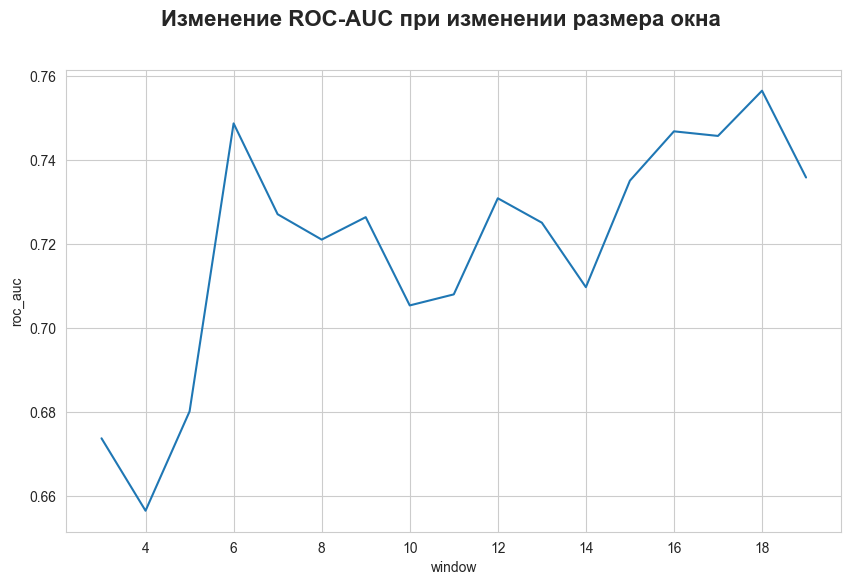

In [18]:
plt.figure(figsize=(10, 6))
data = pd.DataFrame(best_models)
sns.lineplot(x="window", y="roc_auc", data=data)
plt.suptitle("Изменение ROC-AUC при изменении размера окна", weight="bold", fontsize=16)
plt.show()

Обучим word2vec на текстах пресс-релизов

In [19]:
# инициализируем модель w2v
w2v = Word2Vec(
    sentences=texts, window=18, min_count=5, vector_size=128, sg=1, epochs=100
)

# вычисляем эмбеддинги текстов по среднему эмбеддингов слов
embedings = texts.map(lambda x: [w2v.wv[word] for word in x if word in w2v.wv])
embedings = embedings.map(lambda x: np.array(x).sum(0))
embedings_w2v = np.array([arr.tolist() for arr in embedings])

In [21]:
auc = []
for max_depth in tqdm(range(3, 26)):
    auc.append(
        calc_metrics(
            embedings_w2v,
            y,
            RandomForestClassifier,
            name="",
            plot=False,
            n_jobs=-1,
            max_depth=max_depth,
            random_state=42,
        )
    )

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 23/23 [03:03<00:00,  7.96s/it]

Лучшая модель - RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=42)
ROC-AUC = 0.7054509182655636


              precision    recall  f1-score   support

        -1.0       0.60      0.52      0.56        23
         0.0       0.47      0.62      0.53        26
         1.0       0.71      0.53      0.61        19

    accuracy                           0.56        68
   macro avg       0.59      0.55      0.57        68
weighted avg       0.58      0.56      0.56        68



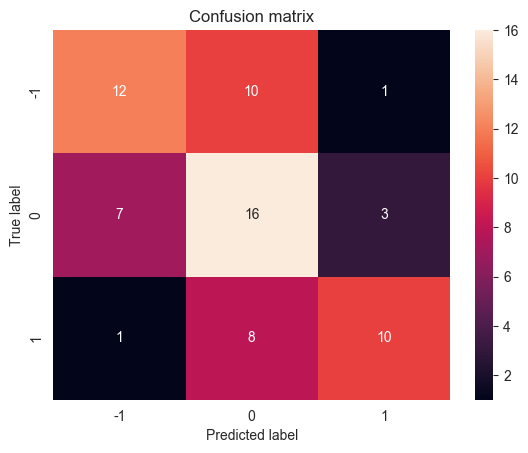

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF SelectFromModel Random Forest,0.647059,0.656532,0.645866,0.677083,0.802227,0.808690
TF-IDF PCA Random Forest,0.632353,0.631884,0.620548,0.681082,0.817684,0.822178
Word2Vec Random Forest,0.558824,0.565844,0.554480,0.594958,0.700217,0.705451


In [22]:
metric, model = calc_metrics(
    embedings_w2v,
    y,
    RandomForestClassifier,
    name="Word2Vec Random Forest",
    **best_model.get_params()
)
metrics = pd.concat([metrics, metric], axis=0)
metrics

Кодирование текстов с помощью `word2vec` показывает качество намного хуже.

Мы протестировали три различных пайплайна со случайным лесом в качестве классификатора. Для каждого мы подбирали гиперпараметры с помощью кросс-валидации. Лучшую оценку показал пайплайн, в котором тексты кодировались с помощью TF-IDF, методом снижения размерности служил PCA. По матрице ошибок лучшей модели можем заметить, что модель хуже всего детектируем первый класс(повышение ставки), только 9 релизов которым предшествовало повышение модель определила правильно в остальных 10 случаях повышения ставки модель ошиблась, единожды модель перепутала повышение ставки и понижение ставки.

Кодирование текстов с помощью word2vec, как и в случае с линейными моделями, значительно отстает по качеству от TF-IDF. 